<a href="https://colab.research.google.com/github/TanDuong986/GCN_Vietnamese_invoice/blob/combination/Gen_Data_GCN_VN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gdown
gdown.download(url='https://drive.google.com/file/d/1KOKuhPErYlJs7l_54lNYfa4Z0DOFMQlm/view',fuzzy=True)
!unzip /content/preprocessed_data.zip -d /content/
!unzip /content/preprocessed_data/images.zip -d /content/preprocessed_data/
%cd /content/preprocessed_data/
!mkdir label_mcocr2021
!mkdir material

In [ ]:
!pip install torch_geometric
!pip install gdown
!pip install bpemb
!pip install sentence-transformers

## Prepare part

### Convert label

In [ ]:
import json
import csv
import pandas as pd
import ast

def convert_to_list_of_integers(input_string):
    return ast.literal_eval(input_string)

def convert_to_list(input_string):
    # Remove leading '[' and trailing ']' from the string and split by comma
    return [int(num) for num in input_string[1:-1].split(', ')]

col = ['cells', 'poly', 'cate_id', 'cate_text', 'vietocr_text', 'group_id']
with open('/content/preprocessed_data/mcocr_labels.json','r') as f:
    data = json.load(f)
for i in data.keys(): #name of all image
    employee_data = data[i]
    df = pd.DataFrame(employee_data["cells"],columns=["poly", "cate_id", "cate_text", "vietocr_text", "group_id"])
    df.drop(["group_id"], axis=1, inplace=True)
    df.to_csv('/content/preprocessed_data/label_mcocr2021/'+str(i) + '.csv',index=False)

### Graph class


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt

class Grapher:
    """
    Description:
            This class is used to generate:
                    1) the graph (in dictionary form) { source_node: [destination_node1, destination_node2]}
                    2) the dataframe with relative_distances

    Inputs: The class consists of a pandas dataframe consisting of cordinates for bounding boxe and the image of the invoice/receipt.

    """
    def __init__(self, filename, data_fd):
        self.filename = filename
        self.data_fd = data_fd

        # tim path den file label box
        file_path = os.path.join(self.data_fd, "label_mcocr2021",filename + '.jpg.csv')

        #path cua image roi - concat file name -> absolute path of image
        image_path = os.path.join(self.data_fd, "images", filename + '.jpg')

        #read box file not have label
        with open(file_path,'r') as f:
            self.df = pd.read_csv(f)
        # self.df.drop(["cells index","cate_id","group_id"], axis=1, inplace=True)

        #read that image
        self.image = cv2.imread(image_path)

    def convert_to_list(self,input_string):
        return [int(num) for num in input_string[1:-1].split(', ')]

    def graph_formation(self, export_graph = False):
        df, image = self.df, self.image
        """
        preprocessing the raw csv files to favorable df
        """
        df['poly'] = df['poly'].apply(self.convert_to_list)

        # Create separate columns for each element in the lists
        df_split = pd.DataFrame(df['poly'].to_list(), columns=[f'pos{i+1}' for i in range(8)])

        # Concatenate the original DataFrame with the new split columns
        df = pd.concat([ df_split,df], axis=1)

        # Drop the original column with the string representations of lists
        df.drop(['poly','pos3','pos4','pos7','pos8'], axis=1, inplace=True)
        new_name_and_order = {'pos1':'xmin','pos2':'ymin','pos5':'xmax','pos6':'ymax','cate_id':'label_id','cate_text':'label_text','vietocr_text':'content'}
        # column = ['label_id','label_text','content','xmin','ymin','xmax','ymax']
        df = df[list(new_name_and_order.keys())].rename(columns=new_name_and_order)
        for col in df.columns:
            try:
                df[col] = df[col].str.strip()
            except AttributeError:
                pass


        df.dropna(inplace=True)
        #sort from top to bottom
        df.sort_values(by=['ymin'], inplace=True)
        df.reset_index(drop=True, inplace=True)

        #subtracting ymax by 1 to eliminate ambiguity of boxes being in both left and right
        df["ymax"] = df["ymax"].apply(lambda x: x - 1)

        master = []
        for idx, row in df.iterrows():
            # print(idx,row)
            #flatten the nested list
            flat_master = list(itertools.chain(*master))
            #check to see if idx is in flat_master
            if idx not in flat_master:
                top_a = row['ymin']
                bottom_a = row['ymax']
                #every line will atleast have the word in it
                line = [idx]
                for idx_2, row_2 in df.iterrows():
                    #check to see if idx_2 is in flat_master removes ambiguity
                    #picks higher cordinate one.
                    if idx_2 not in flat_master:
                    #if not the same words
                        if not idx == idx_2:
                            top_b = row_2['ymin']
                            bottom_b = row_2['ymax']
                            if (top_a <= bottom_b) and (bottom_a >= top_b):
                                line.append(idx_2)
                master.append(line)
        df2 = pd.DataFrame({'words_indices': master, 'line_number':[x for x in range(1,len(master)+1)]})
        #explode the list columns eg : [1,2,3]
        df2 = df2.set_index('line_number').words_indices.apply(pd.Series).stack()\
                .reset_index(level=0).rename(columns={0:'words_indices'})
        df2['words_indices'] = df2['words_indices'].astype('int')
        #put the line numbers back to the list
        final = df.merge(df2, left_on=df.index, right_on='words_indices')
        final.drop('words_indices', axis=1, inplace=True)

        """
        3) Sort words in each line based on Left coordinate
        """
        final2 =final.sort_values(by=['line_number','xmin'],ascending=True)\
                .groupby('line_number')\
                .head(len(final))\
                .reset_index(drop=True)

        df = final2

        df.reset_index(inplace=True)
        grouped = df.groupby('line_number')
        #for undirected graph construction
        horizontal_connections = {}
        #left
        left_connections = {}
        #right
        right_connections = {}
        for _,group in grouped:
            # print(group)
            a = group['index'].tolist()
            b = group['index'].tolist()
            horizontal_connection = {a[i]:a[i+1] for i in range(len(a)-1) }
            #storing directional connections
            right_dict_temp = {a[i]:{'right':a[i+1]} for i in range(len(a)-1) }
            left_dict_temp = {b[i+1]:{'left':b[i]} for i in range(len(b)-1) }

            #add the indices in the dataframes
            for i in range(len(a)-1):
                df.loc[df['index'] == a[i], 'right'] = int(a[i+1])
                df.loc[df['index'] == a[i+1], 'left'] = int(a[i])

            left_connections.update(right_dict_temp)
            right_connections.update(left_dict_temp)
            horizontal_connections.update(horizontal_connection)

        dic1,dic2 = left_connections, right_connections

        #verticle connections formation
        bottom_connections = {}
        top_connections = {}

        for idx, row in df.iterrows():
            if idx not in bottom_connections.keys():
                right_a = row['xmax']
                left_a = row['xmin']

                for idx_2, row_2 in df.iterrows():
                    #check for higher idx values

                    if idx_2 not in bottom_connections.values() and idx < idx_2:
                            right_b = row_2['xmax']
                            left_b = row_2['xmin']
                            if (left_b <= right_a) and (right_b >= left_a):
                                bottom_connections[idx] = idx_2
                                top_connections[idx_2] = idx

                                #add it to the dataframe
                                df.loc[df['index'] == idx , 'bottom'] = idx_2
                                df.loc[df['index'] == idx_2, 'top'] = idx
                                #print(bottom_connections)
                                #once the condition is met, break the loop to reduce redundant time complexity
                                break

        #combining both
        result = {}
        dic1 = horizontal_connections
        dic2 = bottom_connections

        for key in (dic1.keys() | dic2.keys()):
            if key in dic1: result.setdefault(key, []).append(dic1[key])
            if key in dic2: result.setdefault(key, []).append(dic2[key])
        # print(result)

        G = nx.from_dict_of_lists(result)

        if export_graph:
            here = os.path.dirname(os.path.abspath(__file__))
            should_save_dir = os.path.join(here,'figures/')
            if not os.path.exists(should_save_dir):
                os.makedirs(should_save_dir)

            plot_path = should_save_dir + self.filename + 'plain_graph' '.jpg'
            # print(plot_path)
            layout = nx.kamada_kawai_layout(G)
            layout = nx.spring_layout(G)
            nx.draw(G, layout, with_labels=True)
            plt.savefig(plot_path, format="JPG", dpi=600)
            #plt.show()

        # connect with the interim file that has labels in it
        # df['labels'] = self.df_withlabels['9']
        self.df = df
        return G,result, df


    def get_text_features(self, df):
        """
        gets text features

        Args: df
        Returns: n_lower, n_upper, n_spaces, n_alpha, n_numeric,n_special
        """
        data = df['content'].tolist()

        '''
            Args:
                df

            Returns:
                character and word features

        '''
        special_chars = ['&', '@', '#', '(',')','-','+',
                    '=', '*', '%', '.', ',', '\\','/',
                    '|', ':']

        # character wise
        n_lower, n_upper, n_spaces, n_alpha, n_numeric,n_special = [],[],[],[],[],[]

        for words in data:
            lower, upper,alpha,spaces,numeric,special = 0,0,0,0,0,0
            for char in words:
                if char.islower():
                    lower += 1
                # for upper letters
                if char.isupper():
                    upper += 1
                # for white spaces
                if char.isspace():
                    spaces += 1
                # for alphabetic chars
                if char.isalpha():
                    alpha += 1
                # for numeric chars
                if char.isnumeric():
                    numeric += 1
                if char in special_chars:
                    special += 1

            n_lower.append(lower)
            n_upper.append(upper)
            n_spaces.append(spaces)
            n_alpha.append(alpha)
            n_numeric.append(numeric)
            n_special.append(special)
            #features.append([n_lower, n_upper, n_spaces, n_alpha, n_numeric, n_digits])

        df['n_upper'],df['n_alpha'],df['n_spaces'],\
        df['n_numeric'],df['n_special'] = n_upper, n_alpha, n_spaces, n_numeric,n_special

    def relative_distance(self, export_document_graph = False):
        """
        1) Calculates relative distances for each node in left, right, top  and bottom directions if they exist.
        rd_l, rd_r = relative distances left , relative distances right. The distances are divided by image width
        rd_t, rd_b = relative distances top , relative distances bottom. The distances are divided by image length

        2) Exports the complete document graph for visualization

        Args:
            result dataframe from graph_formation()

        returns:
            dataframe with features and exports document graph if prompted
        """

        df, img = self.df, self.image
        image_height, image_width = self.image.shape[0], self.image.shape[1]
        plot_df = df.copy()
        for index in df['index'].to_list():
            right_index = df.loc[df['index'] == index, 'right'].values[0]
            left_index = df.loc[df['index'] == index, 'left'].values[0]
            bottom_index = df.loc[df['index'] == index, 'bottom'].values[0]
            top_index = df.loc[df['index'] == index, 'top'].values[0]

            #check if it is nan value
            if np.isnan(right_index) == False:
                right_word_left = df.loc[df['index'] == right_index, 'xmin'].values[0]
                source_word_right = df.loc[df['index'] == index, 'xmax'].values[0]
                df.loc[df['index'] == index, 'rd_r'] = (right_word_left - source_word_right)/image_width

                """
                for plotting purposes
                getting the mid point of the values to draw the lines for the graph
                mid points of source and destination for the bounding boxes
                """
                right_word_x_max = df.loc[df['index'] == right_index, 'xmax'].values[0]
                right_word_y_max = df.loc[df['index'] == right_index, 'ymax'].values[0]
                right_word_y_min = df.loc[df['index'] == right_index, 'ymin'].values[0]

                df.loc[df['index'] == index, 'destination_x_hori'] = (right_word_x_max + right_word_left)/2
                df.loc[df['index'] == index, 'destination_y_hori'] = (right_word_y_max + right_word_y_min)/2

            if np.isnan(left_index) == False:
                left_word_right = df.loc[df['index'] == left_index, 'xmax'].values[0]
                source_word_left = df.loc[df['index'] == index, 'xmin'].values[0]
                df.loc[df['index'] == index, 'rd_l'] = (left_word_right - source_word_left)/image_width

            if np.isnan(bottom_index) == False:
                bottom_word_top = df.loc[df['index'] == bottom_index, 'ymin'].values[0]
                source_word_bottom = df.loc[df['index'] == index, 'ymax'].values[0]
                df.loc[df['index'] == index, 'rd_b'] = (bottom_word_top - source_word_bottom)/image_height

                """for plotting purposes"""
                bottom_word_top_max = df.loc[df['index'] == bottom_index, 'ymax'].values[0]
                bottom_word_x_max = df.loc[df['index'] == bottom_index, 'xmax'].values[0]
                bottom_word_x_min = df.loc[df['index'] == bottom_index, 'xmin'].values[0]
                df.loc[df['index'] == index, 'destination_y_vert'] = (bottom_word_top_max + bottom_word_top)/2
                df.loc[df['index'] == index, 'destination_x_vert'] = (bottom_word_x_max + bottom_word_x_min)/2

            if np.isnan(top_index) == False:
                top_word_bottom = df.loc[df['index'] == top_index, 'ymax'].values[0]
                source_word_top = df.loc[df['index'] == index, 'ymin'].values[0]
                df.loc[df['index'] == index, 'rd_t'] = (top_word_bottom - source_word_top)/image_height

        #replace all tne NaN values with '0' meaning there is nothing in that direction
        df[['rd_r','rd_b','rd_l','rd_t']] = df[['rd_r','rd_b','rd_l','rd_t']].fillna(0)

        if export_document_graph:
            for idx, row in df.iterrows():
        #bounding box
                cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 0, 255), 2)

                if np.isnan(row['destination_x_vert']) == False:
                    source_x = (row['xmax'] + row['xmin'])/2
                    source_y = (row['ymax'] + row['ymin'])/2

                    cv2.line(img,
                            (int(source_x), int(source_y)),
                            (int(row['destination_x_vert']), int(row['destination_y_vert'])),
                            (0,255,0), 2)


                    text = "{:.3f}".format(row['rd_b'])
                    text_coordinates = ( int((row['destination_x_vert'] + source_x)/2) , int((row['destination_y_vert'] +source_y)/2))
                    cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

                    #text_coordinates = ((row['destination_x_vert'] + source_x)/2 , (row['destination_y_vert'] +source_y)/2)

                if np.isnan(row['destination_x_hori']) == False:
                    source_x = (row['xmax'] + row['xmin'])/2
                    source_y = (row['ymax'] + row['ymin'])/2

                    cv2.line(img,
                        (int(source_x), int(source_y)),
                        (int(row['destination_x_hori']), int(row['destination_y_hori'])), \
                        (0,255,0), 2)

                    text = "{:.3f}".format(row['rd_r'])
                    text_coordinates = (int((row['destination_x_hori'] + source_x)/2) , int((row['destination_y_hori'] +source_y)/2))
                    cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

            # cv2.imshow("image", img)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
                if not os.path.exists('../../figures/graphs'):
                    os.makedirs('../../figures/graphs')

                plot_path ='../../figures/graphs/' + self.filename + 'docu_graph' '.jpg'
                cv2.imwrite(plot_path, img)

        #drop the unnecessary columns
        df.drop(['destination_x_hori', 'destination_y_hori','destination_y_vert','destination_x_vert'], axis=1, inplace=True)
        self.get_text_features(df)
        return df

### Generate data

In [ ]:
import os
from sentence_transformers import SentenceTransformer
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn.conv import ChebConv,GCNConv
import torch_geometric
from sklearn.utils.class_weight import compute_class_weight

from numpy import random
import tqdm
import numpy as np
import os

data_fd ='/content/preprocessed_data'
label_pth = os.path.join(data_fd,'label_mcocr2021')
save_fd = '/content/preprocessed_data/material'


sent_model = SentenceTransformer('keepitreal/vietnamese-sbert')
def make_sent_bert_features(text):
    emb = sent_model.encode([text])[0]
    return emb

# def get_data(save_fd):
#     """
#     returns one big graph with unconnected graphs with the following:
#     - x (Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)
#     - edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)
#     - edge_attr (Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)
#     - y (Tensor, optional) – Graph or node targets with arbitrary shape. (default: None)
#     - validation mask, training mask and testing mask
#     """

path = label_pth
files = [i.split('.')[0] for i in os.listdir(path)]
files.sort()
# error_id = unique()
all_files = files[1:] # don't take the first file, this is header
# all_files = list(set(all_files) - set(error_id))
# all_files.sort()

list_of_graphs = []
train_list_of_graphs, test_list_of_graphs = [], []

files = all_files.copy()
random.shuffle(files)

"""Resulting in 550 receipts for training"""
training, testing = files[:872], files[872:] # 80% of 1090

for file in tqdm.tqdm_notebook (all_files):
    connect = Grapher(file, data_fd)
    G,_,_ = connect.graph_formation()
    df = connect.relative_distance()
    individual_data = from_networkx(G)
    # print(df['num_labels'])

    feature_cols = ['rd_b', 'rd_r', 'rd_t', 'rd_l','line_number', \
            'n_upper', 'n_alpha', 'n_spaces', 'n_numeric','n_special']

    text_features = np.array(df["content"].map(make_sent_bert_features).tolist()).astype(np.float32)
    numeric_features = df[feature_cols].values.astype(np.float32)

    features = np.concatenate((numeric_features, text_features), axis=1)
    features = torch.tensor(features)

    for col in df.columns:
        try:
            df[col] = df[col].str.strip()
        except AttributeError as e:
            pass

    # df['labels'] = df['labels'].fillna('undefined')
    df.loc[df['label_text'] == 'SELLER', 'num_labels'] = 1
    df.loc[df['label_text'] == 'ADDRESS', 'num_labels'] = 2
    df.loc[df['label_text'] == 'TIMESTAMP', 'num_labels'] = 3
    df.loc[df['label_text'] == 'TOTAL_COST', 'num_labels'] = 4
    df.loc[df['label_text'] == 'OTHER', 'num_labels'] = 5
    # df.loc[df['labels_text'] == 'invoice', 'num_labels'] = 5 # this code do not use 'invoice' label so make it into background

    assert df['num_labels'].isnull().values.any() == False, f'labeling error! Invalid label(s) present in {file}.csv'
    labels = torch.tensor(df['num_labels'].values.astype(np.int8))
    text = df['content'].values

    individual_data.x = features
    individual_data.y = labels
    individual_data.text = text
    individual_data.img_id = file

    if file in training:
        train_list_of_graphs.append(individual_data)
    elif file in testing:
        test_list_of_graphs.append(individual_data)
      # df now is a data frame have 22 columns and 71 row, object is text had embedding to feature
train_data = torch_geometric.data.Batch.from_data_list(train_list_of_graphs)
train_data.edge_attr = None
test_data = torch_geometric.data.Batch.from_data_list(test_list_of_graphs)
test_data.edge_attr = None

torch.save(train_data, os.path.join(save_fd, 'train_dataVN.dataset'))
torch.save(test_data, os.path.join(save_fd, 'test_dataVN.dataset'))


KeyboardInterrupt: ignored

## Train part


### Model class

In [ ]:
from torch_geometric.nn.conv import ChebConv,GCNConv
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class InvoiceGCN(nn.Module):

    def __init__(self, input_dim, chebnet=False, n_classes=5, dropout_rate=0.2, K=3):
        super().__init__()

        self.input_dim = input_dim
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate

        if chebnet:
            self.conv1 = ChebConv(self.input_dim, 64, K=K)
            self.conv2 = ChebConv(64, 32, K=K)
            self.conv3 = ChebConv(32, 16, K=K)
            self.conv4 = ChebConv(16, self.n_classes, K=K)
        else:
            self.conv1 = GCNConv(self.first_dim, 64, improved=True, cached=True)
            self.conv2 = GCNConv(64, 32, improved=True, cached=True)
            self.conv3 = GCNConv(32, 16, improved=True, cached=True)
            self.conv4 = GCNConv(16, self.n_classes, improved=True, cached=True)

    def forward(self, data):
        # for transductive setting with full-batch update
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        x = F.dropout(F.relu(self.conv1(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = F.dropout(F.relu(self.conv2(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = F.dropout(F.relu(self.conv3(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = self.conv4(x, edge_index, edge_weight)

        return F.log_softmax(x, dim=1)


################################# different model #######################

class GraphConvolution(nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        dropout=0.2,
        bias=True,
        activation=F.relu,
    ):
        super().__init__()

        if dropout:
            self.dropout = dropout
        else:
            self.dropout = 0.0

        self.bias = bias
        self.activation = activation

        def glorot(shape, name=None):
            """Glorot & Bengio (AISTATS 2010) init."""
            init_range = np.sqrt(6.0 / (shape[0] + shape[1]))
            init = torch.FloatTensor(shape[0], shape[1]).uniform_(
                -init_range, init_range
            )
            return init

        self.weight = nn.Parameter(glorot((input_dim, output_dim)))
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.zeros(output_dim))

    def forward(self, inputs):
        # node feature, adj matrix
        # D^(-1/2).A.D^(-1/2).H_i.W_i
        # with H_0 = X (init node features)
        # V, A
        x, support = inputs

        x = F.dropout(x, self.dropout)
        xw = torch.mm(x, self.weight)
        out = torch.sparse.mm(support, xw)

        if self.bias is not None:
            out += self.bias

        if self.activation is None:
            return out, support
        else:
            return self.activation(out), support

class LinearEmbedding(torch.nn.Module):

    def __init__(self, input_size, output_size, use_act="relu"):
        super().__init__()
        self.C = output_size
        self.F = input_size

        self.W = nn.Parameter(torch.FloatTensor(self.F, self.C))
        self.B = nn.Parameter(torch.FloatTensor(self.C))

        if use_act == "relu":
            self.act = torch.nn.ReLU()
        elif use_act == "softmax":
            self.act = torch.nn.Softmax(dim=-1)
        else:
            self.act = None

        nn.init.xavier_normal_(self.W)
        nn.init.normal_(self.B, mean=1e-4, std=1e-5)

    def forward(self, V):
        # V shape B,N,F
        # V: node features
        V_out = torch.matmul(V, self.W) + self.B
        if self.act:
            V_out = self.act(V_out)

        return V_out

class GCN(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dims=[256, 128, 64],
                 bias=True, dropout_rate=0.1):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.bias = bias
        self.dropout_rate = dropout_rate

        gcn_layers = []
        for index, (h1, h2) in enumerate(
            zip(self.hidden_dims[:-1], self.hidden_dims[1:])):
            gcn_layers.append(
                GraphConvolution(
                    h1,
                    h2,
                    activation=None if index == len(self.hidden_dims) else F.relu,
                    bias=self.bias,
                    dropout=self.dropout_rate,
                    is_sparse_inputs=False
                )
            )

        self.layers = nn.Sequential(*gcn_layers)
        self.linear1 = LinearEmbedding(input_dim, self.hidden_dims[0], use_act='relu')
        self.linear2 = LinearEmbedding(self.hidden_dims[-1], self.output_dim, use_act='relu')

    def forward(self, inputs):
        # features, adj
        x, support = inputs
        x = self.linear1(x)
        x = F.dropout(x, p=self.dropout_rate)
        x, _ = self.layers((x, support))
        x = self.linear2(x)
        return x, support


### Training part

In [ ]:
import torch
import torch.nn.functional as F
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch_geometric.utils.convert import from_networkx

import numpy as np
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import shutil
import os
import time


save_fd = '/content/preprocessed_data/material'
def load_train_test_split(save_fd):
    train_data = torch.load(os.path.join(save_fd, 'train_dataVN.dataset'))
    test_data = torch.load(os.path.join(save_fd, 'test_dataVN.dataset'))
    return train_data, test_data

train_data, test_data = load_train_test_split(save_fd=save_fd)
# print(train_data, test_data)

model = InvoiceGCN(input_dim=train_data.x.shape[1], chebnet=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.001, weight_decay=0.9
)
train_data = train_data.to(device)
test_data = test_data.to(device)

# class weights for imbalanced data
_class_weights = compute_class_weight(
    class_weight="balanced", classes = train_data.y.unique().cpu().numpy(), y= train_data.y.cpu().numpy()
)
print(_class_weights)

no_epochs = 10000
for epoch in range(1, no_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # NOTE: just use boolean indexing to filter out test data, and backward after that!
    # the same holds true with test data :D
    # https://github.com/rusty1s/pytorch_geometric/issues/1928
    loss = F.nll_loss(
        model(train_data), (train_data.y - 1).to(torch.int64), weight=torch.FloatTensor(_class_weights).to(device)
    )
    loss.backward()
    optimizer.step()

    # calculate acc on 5 classes
    with torch.no_grad():
        if epoch % 200 == 0:
            model.eval()

            # forward model
            for index, name in enumerate(['train', 'test']):
                _data = eval("{}_data".format(name))
                y_pred = model(_data).max(dim=1)[1]
                y_true = (_data.y - 1)
                acc = y_pred.eq(y_true).sum().item() / y_pred.shape[0]

                y_pred = y_pred.cpu().numpy()
                y_true = y_true.cpu().numpy()
                print("\t{} acc: {}".format(name, acc))
                # confusion matrix
                if name == 'test':
                    cm = confusion_matrix(y_true, y_pred)
                    class_accs = cm.diagonal() / cm.sum(axis=1)
                    print(classification_report(y_true, y_pred))

            loss_val = F.nll_loss(model(test_data), (test_data.y - 1).to(torch.int64))
            fmt_log = "Epoch: {:03d}, train_loss:{:.4f}, val_loss:{:.4f}"
            print(fmt_log.format(epoch, loss, loss_val))
            print(">" * 50)


## Testing


<ipython-input-8-7ce01d263d89>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(indexes):


  0%|          | 0/217 [00:00<?, ?it/s]

Img index: 0
Img id: mcocr_public_145013aedmq
y_pred: Counter({4: 6, 1: 3, 2: 2, 0: 1})
	Image mcocr_public_145013aedmq: 0.2389507293701172
Img index: 1
Img id: mcocr_public_145013alybg
y_pred: Counter({4: 40, 3: 2, 2: 2, 0: 1, 1: 1})
	Image mcocr_public_145013alybg: 0.5217766761779785
Img index: 2
Img id: mcocr_public_145013anmiz
y_pred: Counter({4: 30, 1: 3, 3: 2, 0: 1, 2: 1})
	Image mcocr_public_145013anmiz: 0.43689846992492676
Img index: 3
Img id: mcocr_public_145013bdnvs
y_pred: Counter({4: 32, 3: 2, 0: 1, 1: 1})
	Image mcocr_public_145013bdnvs: 0.7002949714660645
Img index: 4
Img id: mcocr_public_145013bgfxq
y_pred: Counter({4: 15, 3: 2, 0: 1, 1: 1, 2: 1})
	Image mcocr_public_145013bgfxq: 0.20586276054382324
Img index: 5
Img id: mcocr_public_145013bsywa
y_pred: Counter({4: 31, 3: 2, 0: 1, 1: 1})
	Image mcocr_public_145013bsywa: 0.3456838130950928
Img index: 6
Img id: mcocr_public_145013ckejs
y_pred: Counter({4: 52, 0: 2, 1: 1})
	Image mcocr_public_145013ckejs: 0.6866154670715332


AssertionError: ignored

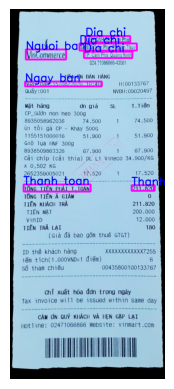

In [ ]:
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from torch_geometric.utils.convert import from_networkx

import numpy as np
import os
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
import tqdm

def make_info(img_id,data_fd ='/content/preprocessed_data',img_fd ='/content/preprocessed_data/images'):
    connect = Grapher(img_id, data_fd)
    G, _, _ = connect.graph_formation()
    df = connect.relative_distance()
    img = cv2.imread(os.path.join(img_fd, "{}.jpg".format(img_id)))[:, :, ::-1]
    return G,df,img

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    save_fd = '/content/preprocessed_data/data'
    test_output_fd = "/content/preprocessed_data/output_fd"

    test_data = torch.load(os.path.join(save_fd, 'test_dataVN.dataset'))
    if not os.path.exists(test_output_fd):
        os.mkdir(test_output_fd)
    model = InvoiceGCN(input_dim=test_data.x.shape[1],chebnet=True) #778 is sum of 768 [embedding] + 10 [spatial and text properties]
    model.load_state_dict(torch.load('/content/preprocessed_data/weight/model_std.pt'))
    model.eval()
    model = model.to(device)
    test_data = test_data.to(device)

    y_preds = model(test_data).max(dim=1)[1].cpu().numpy()
    LABELS = ["Nguoi ban", "Dia chi", "Ngay ban", "Thanh toan", "Khac"]
    test_batch = test_data.batch.cpu().numpy()
    # an array contains information about location of each cell of each sample
    # [ 0 0 0 0 1 1 1 1 1 2 2 2 2 2 .....] 217 sample, loss 1 sample of testing (null)
    indexes = range(len(test_data.img_id))

    # with tqdm(total=total) as pbar:
    for index in tqdm_notebook(indexes):
        start = time.time()
        img_id = test_data.img_id[index]
        sample_indexes = np.where(test_batch == index)[0]
        y_pred = y_preds[sample_indexes]

        print("Img index: {}".format(index))
        print("Img id: {}".format(img_id))
        print("y_pred: {}".format(Counter(y_pred)))
        G,df,img = make_info(img_id)

        assert len(y_pred) == df.shape[0]

        img2 = np.copy(img)
        for row_index, row in df.iterrows():
            x1,y1,x2,y2 = row[['xmin','ymin','xmax','ymax']]
            true_label = row['label_text']

            # if isinstance(true_label,str) and true_label != "invoice":
            #     cv2.rectangle(img2,(x1,y1),(x2,y2),(0,255,0),2)

            y_pred_ = y_pred[row_index]
            if y_pred_ != 4:
                cv2.rectangle(img2,(x1,y1),(x2,y2),(255,0,255),3)
                label_ = LABELS[y_pred_]
                cv2.putText(img2,f'{label_}',(x1,y1),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
            end = time.time()
        print("\tImage {}: {}".format(img_id, end - start))
        plt.imshow(img2)
        plt.axis('off')
        plt.savefig(os.path.join(test_output_fd, '{}_result.png'.format(img_id)), bbox_inches='tight',dpi=300)
        plt.plot



In [ ]:
y_pred

array([4, 4, 1, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 4])

In [ ]:
df.head

<bound method NDFrame.head of     index  xmin  ymin  xmax  ymax  label_id  label_text  \
0       0   396    -1   575    17         0       OTHER   
1       1   352    56   398    71         0       OTHER   
2       2   222   112   528   131        16     ADDRESS   
3       3   322   132   429   146         0       OTHER   
4       4    88   152   234   169        17   TIMESTAMP   
5       5   302   192   450   207         0       OTHER   
6       6    90   216   238   231         0       OTHER   
7       7   346   208   408   219         0       OTHER   
8       8    88   232   138   243         0       OTHER   
9       9    88   246   160   259         0       OTHER   
10     10    86   278   278   295         0       OTHER   
11     11   164   368   222   383         0       OTHER   
12     12   372   370   390   381         0       OTHER   
13     13   584   370   656   385         0       OTHER   
14     14    91   403   148   420         0       OTHER   
15     15    92   386   61